In [137]:
import yfinance as yf
import pandas as pd
import zipfile
import json
from lxml import etree
from io import StringIO
from datetime import date
from tqdm.notebook import tqdm
import requests
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os
import pickle
import numpy as np

In [79]:
# Set directory and device
# set device
device = torch.device(0 if torch.cuda.is_available() else -1)
print('Device:', device)

# set directory for data and model
data_dir = 'dataset/'
model_dir = 'model/'
# create directory for data
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


Device: cuda:0


In [80]:
# List of tickers / companies
temp = pd.read_csv('dataset/combined_2012-01-01_2022-12-31.csv')
companies = temp['ticker'].unique().tolist()
companies_full_name = temp['company_name'].unique().tolist()
# selected_companies = ['GOOGL', 'META', 'BIDU', 'PINS', 'DASH']
# selected_companies = ['GOOGL', 'META', 'BIDU']
selected_companies = ['META']
# selected_companies = ['ADD', 'AMC', 'AMCX', 'ANGI', 'AREN', 'ATHM', 'BIDU', 'BKNG', 'CCL', 'CMCM', 'CNK', 'CNVS', 'DIS', 'DLPN', 'EXPE', 'FENG', 'FWONA', 'GAIA', 'GNUS', 'GOOGL', 'GRPN', 'IAC', 'IMAX', 'IZEA', 'LIND', 'LOV', 'LTRPA', 'LYV', 'MANU', 'MCS', 'META', 'MMYT', 'MOMO', 'MSGS', 'MTCH', 'NCLH', 'NFLX', 'NWSA', 'NXST', 'PARA', 'PERI', 'PLAY', 'RCL', 'RDI', 'SABR', 'SBGI', 'SCOR', 'SIRI', 'SSTK', 'TCOM', 'TNL', 'TOUR', 'TRIP', 'TRUE', 'TTGT', 'WB', 'WBD', 'WWE', 'YELP', 'YY', 'Z']




Historical Stock Data

In [ ]:
# fetch historical stock data from 2012-01-01 to 2022-12-31
company_list = companies
start_date = '2012-01-01'
end_date = '2022-12-31'
filename = data_dir + 'historical_stock_data.csv'

def save_historical_data_to_csv(companies, start_date, end_date, filename):
    data = pd.DataFrame()

    for company in companies:
        print(f'Retrieving data for {company}...')
        stock_data = yf.download(company, start=start_date, end=end_date)
        if not stock_data.empty:
            stock_data['Company'] = company
            data = pd.concat([data, stock_data]) 
        else:
            print(f'No data available for {company}.')
        print()

    if not data.empty:
        data.to_csv(filename)
        print(f'Historical stock data saved to {filename}.')
    else:
        print('No data available for any company.')

save_historical_data_to_csv(company_list, start_date, end_date, filename)

In [81]:
# load stock data from csv file instead of fetching from Yahoo Finance
path = data_dir + 'historical_stock_data.csv'
df_stock = pd.read_csv(path, index_col=0, parse_dates=True)
display(df_stock.head())
print(df_stock.shape)


,Open,High,Low,Close,Adj Close,Volume,Company
Date,,,,,,,
2020-12-10,146.000000,165.000000,141.250000,144.710007,144.710007,70447500,ABNB
2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800,ABNB
2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100,ABNB
2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400,ABNB
2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600,ABNB


(210896, 7)


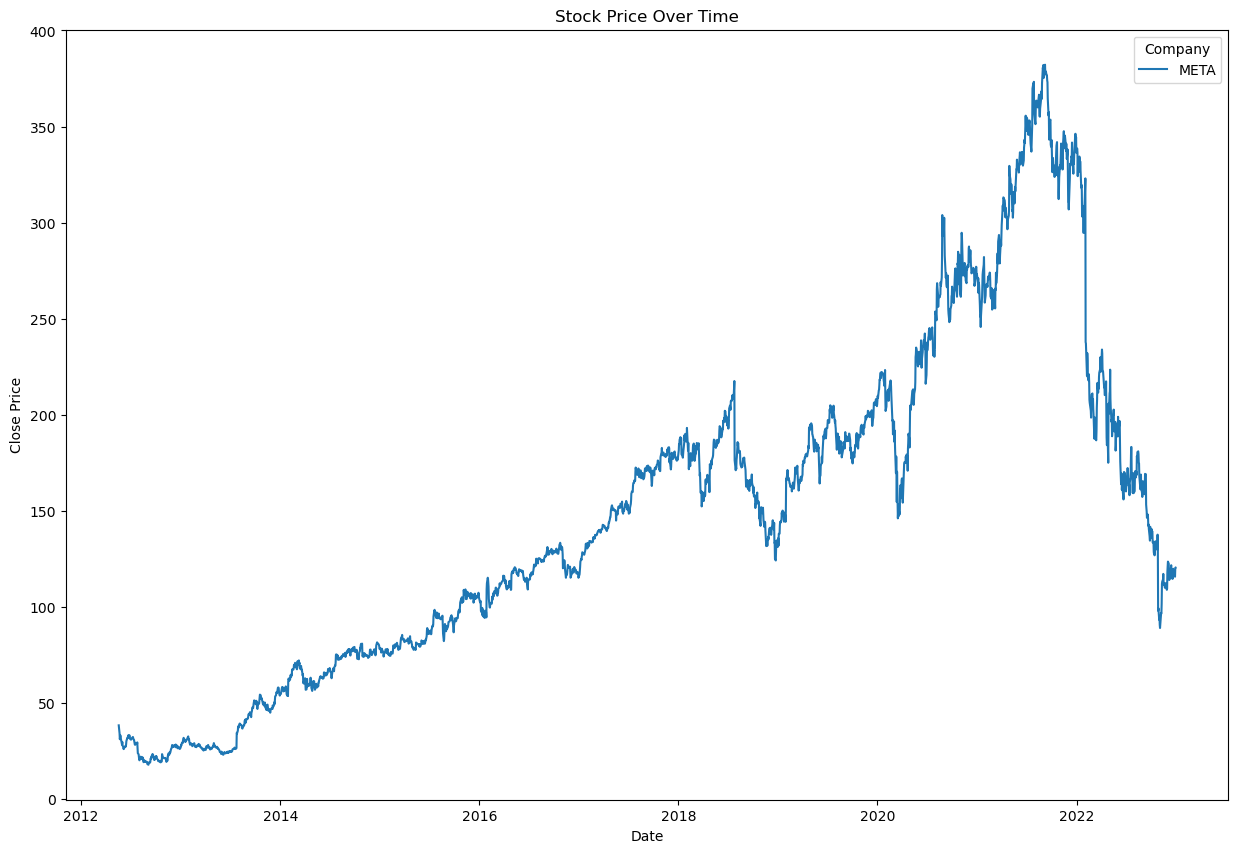

In [5]:
# plot historical stock data
temp = df_stock[df_stock['Company'].isin(selected_companies)]
plt.figure(figsize=(15, 10))
sns.lineplot(data=temp, x='Date', y='Close', hue='Company')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [82]:
# calculate daily returns for each company using pct_change() of closing price
df_stock['daily_return'] = df_stock.groupby('Company')['Close'].pct_change()
df_stock = df_stock.copy()
df_stock = df_stock.reset_index()
display(df_stock[df_stock['Company'] == 'YELP'].head(5))

,Date,Open,High,Low,Close,Adj Close,Volume,Company,daily_return
200134,2012-03-02,22.010000,26.000000,22.000000,24.58,24.58,4809400,YELP,NaN
200135,2012-03-05,24.850000,24.860001,20.900000,20.99,20.99,2988200,YELP,-0.146054
200136,2012-03-06,19.830000,20.500000,19.360001,20.50,20.50,1154300,YELP,-0.023344
200137,2012-03-07,20.450001,20.629999,19.950001,20.25,20.25,444800,YELP,-0.012195
200138,2012-03-08,20.299999,20.389999,19.959999,20.00,20.00,436900,YELP,-0.012346


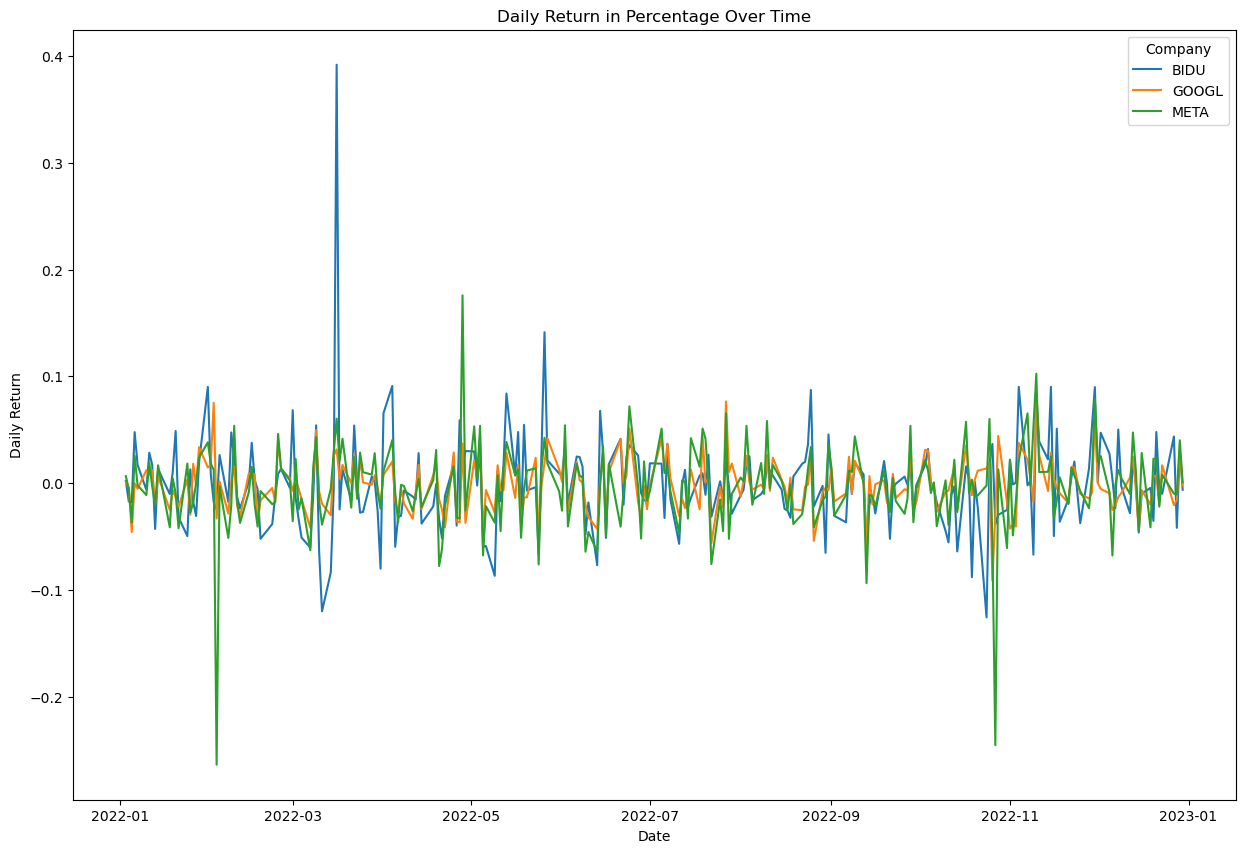

In [33]:
# plot daily returns for selected companies 
temp = df_stock[df_stock['Company'].isin(selected_companies)]
start_date = '2022-01-01'
end_date = '2022-12-31'
temp = temp[(temp['Date'] >= start_date) & (temp['Date'] <= end_date)]
plt.figure(figsize=(15, 10))
sns.lineplot(data=temp, x='Date', y='daily_return', hue='Company')
plt.title('Daily Return in Percentage Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

Fetching News Headlines and Sentiment Analysis

In [83]:
# load sentiment analysis data
path = data_dir + 'combined_2012-01-01_2022-12-31.csv'
df_sentiment = pd.read_csv(path)
df_sentiment = df_sentiment.rename(columns={"ticker": "Company", "end": "Date"})
df_sentiment['Date'] = df_sentiment['Date'].str[:7] # keep only year and month
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date']) + pd.offsets.MonthEnd(1) # set date to end of month
display(df_sentiment.head(5))
print(df_sentiment.shape)

,Company,start,Date,sentiment_company,industry,sentiment_industry,sentiment,company_name
0,ABNB,2012-01-01,2012-01-31,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."
1,ABNB,2012-02-01,2012-02-29,0.0,travel-services,-0.200013,-0.200013,"Airbnb, Inc."
2,ABNB,2012-03-01,2012-03-31,0.0,travel-services,-0.199878,-0.199878,"Airbnb, Inc."
3,ABNB,2012-04-01,2012-04-30,0.0,travel-services,0.000245,0.000245,"Airbnb, Inc."
4,ABNB,2012-05-01,2012-05-31,0.0,travel-services,0.250073,0.250073,"Airbnb, Inc."


(16764, 8)


In [84]:
# resample sentiment analysis data to daily frequency by filling all dates with the same value as the last date of the month
df_sentiment["start"] = pd.to_datetime(df_sentiment["start"])
start_date = max(df_sentiment['start'].min(), df_stock['Date'].min())
end_date = min(df_sentiment['Date'].max(), df_stock['Date'].max())
df_sentiment_list = []

for company in companies:
    df_company = df_sentiment[df_sentiment['Company'] == company]
    df_company = df_company.set_index('Date')
    df_company = df_company.resample('D').bfill() # resample frequency to daily and fill missing dates with next available value
    
    # fill missing values at the beginning of the dataframe
    temp = df_company.iloc[0]
    temp = pd.DataFrame(temp).transpose()
    date = temp.index.item()
    date_range = pd.date_range(start = date.replace(day=1), end = date, freq='D') # create date range from start of month to first date in dataframe
    temp = pd.DataFrame(temp, index=date_range) # create dataframe with date range
    temp = temp.fillna(method='bfill') # fill missing values with next available value
    temp.index.names = ['Date'] # rename index


    df_company = pd.concat([temp, df_company]) 
    df_company = df_company[~df_company.index.duplicated(keep='first')] # remove duplicate dates
    df_sentiment_list.append(df_company)

df_sentiment = pd.concat(df_sentiment_list)
df_sentiment = df_sentiment.reset_index()
display(df_sentiment.head(10))
print(df_sentiment.shape)


,Date,Company,start,sentiment_company,industry,sentiment_industry,sentiment,company_name
0,2012-01-01,ABNB,2012-01-01,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."
1,2012-01-02,ABNB,2012-01-01,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."
2,2012-01-03,ABNB,2012-01-01,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."
3,2012-01-04,ABNB,2012-01-01,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."
4,2012-01-05,ABNB,2012-01-01,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."
5,2012-01-06,ABNB,2012-01-01,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."
6,2012-01-07,ABNB,2012-01-01,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."
7,2012-01-08,ABNB,2012-01-01,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."
8,2012-01-09,ABNB,2012-01-01,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."
9,2012-01-10,ABNB,2012-01-01,0.0,travel-services,-0.047717,-0.047717,"Airbnb, Inc."


(510286, 8)


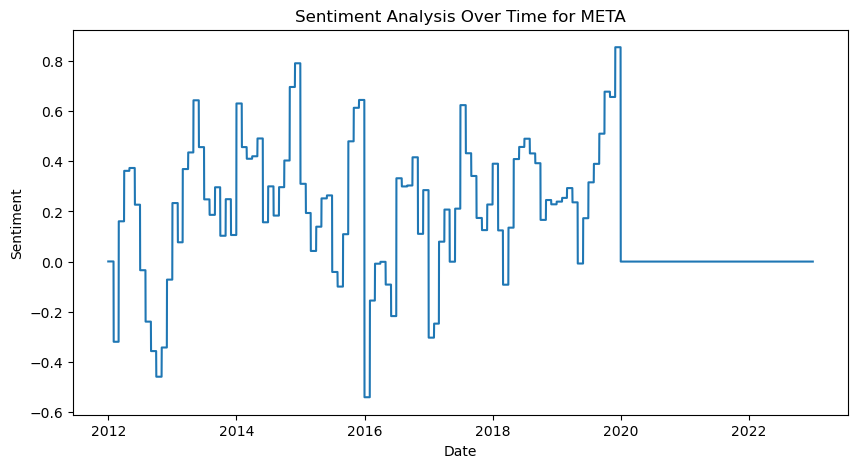

In [10]:
# plot sentiment distribution for each company
for company in selected_companies:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_sentiment[df_sentiment['Company'] == company], x='Date', y='sentiment')
    plt.title(f'Sentiment Analysis Over Time for {company}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.show()

Merge Stock Data and News Headlines

In [85]:
# merge stock data and sentiment analysis
df_merged = pd.merge(df_stock, df_sentiment, left_on=['Company', 'Date'], right_on=['Company', 'Date'], how='inner')
df_merged = df_merged.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'start'])
df_merged = df_merged.set_index('Date') # set date as index
# fill missing values with 0
df_merged['daily_return'] = df_merged['daily_return'].fillna(0.0)
# move daily_return to the end
temp = df_merged.pop('daily_return')
df_merged['daily_return'] = temp

display(df_merged.head(5))
print(df_merged.shape)

,Company,sentiment_company,industry,sentiment_industry,sentiment,company_name,daily_return
Date,,,,,,,
2020-12-10,ABNB,0.0,travel-services,0.0,0.0,"Airbnb, Inc.",0.000000
2020-12-11,ABNB,0.0,travel-services,0.0,0.0,"Airbnb, Inc.",-0.037731
2020-12-14,ABNB,0.0,travel-services,0.0,0.0,"Airbnb, Inc.",-0.066427
2020-12-15,ABNB,0.0,travel-services,0.0,0.0,"Airbnb, Inc.",-0.040000
2020-12-16,ABNB,0.0,travel-services,0.0,0.0,"Airbnb, Inc.",0.105689


(210896, 7)


In [86]:
# create separate dataframes for each company
df_merged_list = []

# create separate dataframes for selected companies
for company in selected_companies:
    df_merged_company = df_merged[df_merged["Company"] == company]
    df_merged_company = df_merged_company.sort_index() # sort by date
    df_merged_company = df_merged_company.dropna() # drop rows with NaN values
    df_merged_company = df_merged_company.drop(columns = ["Company", "industry", "company_name"]) # drop categorical features
    df_merged_list.append(df_merged_company)
print(len(df_merged_list))

# # create separate dataframes for all companies
# for company in companies:
#     df_merged_company = df_merged[df_merged["Company"] == company]
#     df_merged_company = df_merged_company.sort_index() # sort by date
#     df_merged_company = df_merged_company.dropna() # drop rows with NaN values
#     df_merged_company = df_merged_company.drop(columns = ["Company", "industry", "company_name"]) # drop categorical features
#     df_merged_list.append(df_merged_company)
# print(len(df_merged_list))

1


In [51]:
# calculate monthly returns for each company using resample() of daily returns

df_stock["Date"] = pd.to_datetime(df_stock["Date"]) # convert to datetime
df_stock = df_stock.set_index("Date") # set index to date
df_stock_list = []

for company in companies:
    df_stock_company = df_stock[df_stock['Company'] == company]
    # check if dataframes are empty
    if df_stock_company.empty:
        empty_df_stock_company = pd.DataFrame(columns=["monthly_daily_return_median", "Open", "High", "Low", "Close", "Adj Close", "Volume", "Company"], index=pd.to_datetime(["2022-12-31"]))
        # empty_df_stock_company = empty_df_stock_company.append({"monthly_daily_return_median": 0, "Open": 0, "High": 0, "Low": 0, "Close": 0, "Adj Close": 0, "Volume": 0, "Company": company})
        empty_df_stock_company.loc[pd.to_datetime("2022-12-31")] = {"monthly_daily_return_median": 0, "Open": 0, "High": 0, "Low": 0, "Close": 0, "Adj Close": 0, "Volume": 0, "Company": company}
        df_stock_list.append(empty_df_stock_company)
        continue
    df_stock_company_monthly = df_stock_company["daily_return"].resample("M").mean()
    df_stock_company_monthly = df_stock_company_monthly.rename("monthly_daily_return_median")
    df_stock_company_monthly_last_date = df_stock_company.resample("M").last()
    df_stock_company_monthly_last_date = df_stock_company_monthly_last_date.drop(columns=["daily_return"])
    df_stock_company = pd.concat([df_stock_company_monthly, df_stock_company_monthly_last_date], axis=1)
    df_stock_list.append(df_stock_company)

df_stock = pd.concat(df_stock_list)
df_stock = df_stock.reset_index()
df_stock = df_stock.rename(columns={"index": "Date"})
print(df_stock.shape)
display(df_stock.head(5))
display(df_stock[df_stock['Company'] == 'ASST'].head())
display(df_stock[df_stock['Company'] == 'GOOGL'].head(10))


(10096, 9)


,Date,monthly_daily_return_median,Open,High,Low,Close,Adj Close,Volume,Company
0,2020-12-31,0.002146,146.899994,147.889999,144.509995,146.800003,146.800003,2795800,ABNB
1,2021-01-31,0.013426,190.710007,193.5,179.309998,183.630005,183.630005,4529800,ABNB
2,2021-02-28,0.007287,194.179993,214.100006,185.75,206.350006,206.350006,19368600,ABNB
3,2021-03-31,-0.003497,185.429993,192.274994,185.130005,187.940002,187.940002,3079500,ABNB
4,2021-04-30,-0.003833,173.003998,176.449997,172.009995,172.710007,172.710007,3580000,ABNB


,Date,monthly_daily_return_median,Open,High,Low,Close,Adj Close,Volume,Company
754,2022-12-31,0,0,0,0,0,0,0,ASST


,Date,monthly_daily_return_median,Open,High,Low,Close,Adj Close,Volume,Company
3246,2012-01-31,-0.006933,14.58959,14.614615,14.393143,14.517267,14.517267,85610304,GOOGL
3247,2012-02-29,0.003228,15.48048,15.655656,15.402903,15.471722,15.471722,125350524,GOOGL
3248,2012-03-31,0.001708,16.310061,16.353603,16.04104,16.047047,16.047047,92335572,GOOGL
3249,2012-04-30,-0.002808,15.34009,15.417417,15.03028,15.136386,15.136386,96195708,GOOGL
3250,2012-05-31,-0.001711,14.732733,14.764765,14.489489,14.536036,14.536036,118613268,GOOGL
3251,2012-06-30,0.000032,14.388388,14.517768,14.319319,14.516266,14.516266,100679220,GOOGL
3252,2012-07-31,0.004252,15.722222,15.928428,15.721221,15.84009,15.84009,74549376,GOOGL
3253,2012-08-31,0.003493,17.117117,17.231731,17.018019,17.144394,17.144394,84998916,GOOGL
3254,2012-09-30,0.005143,18.872623,19.001501,18.797548,18.88138,18.88138,111228660,GOOGL
3255,2012-10-31,-0.004729,17.013514,17.042042,16.891891,17.024525,17.024525,61418520,GOOGL


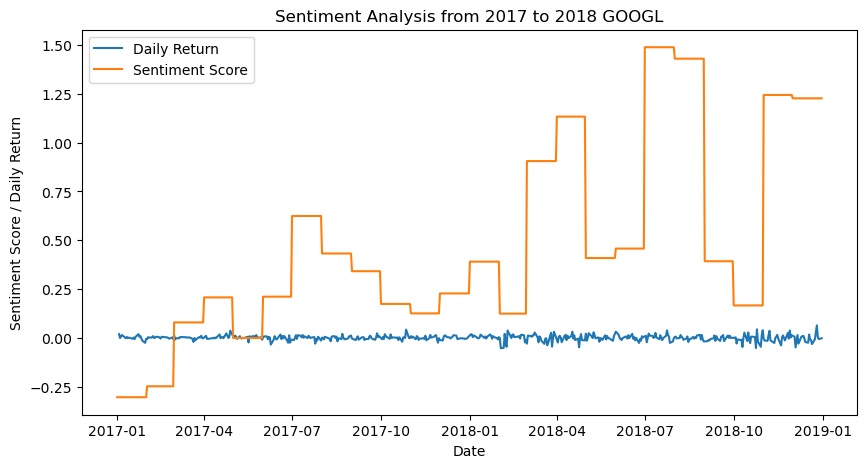

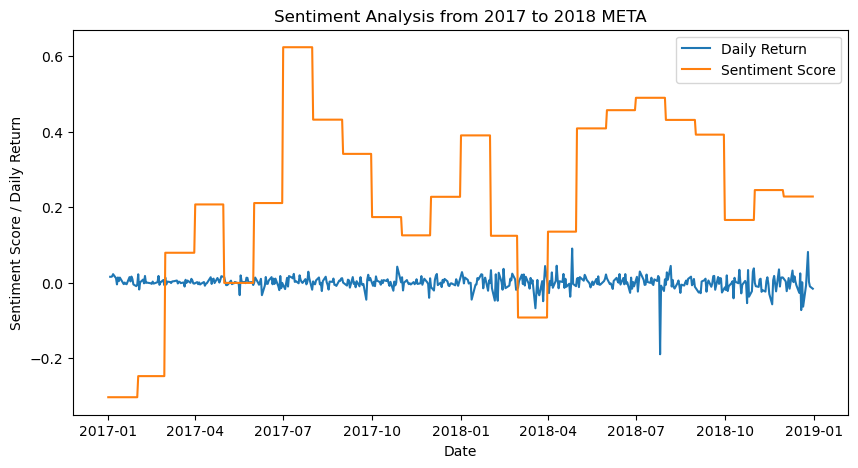

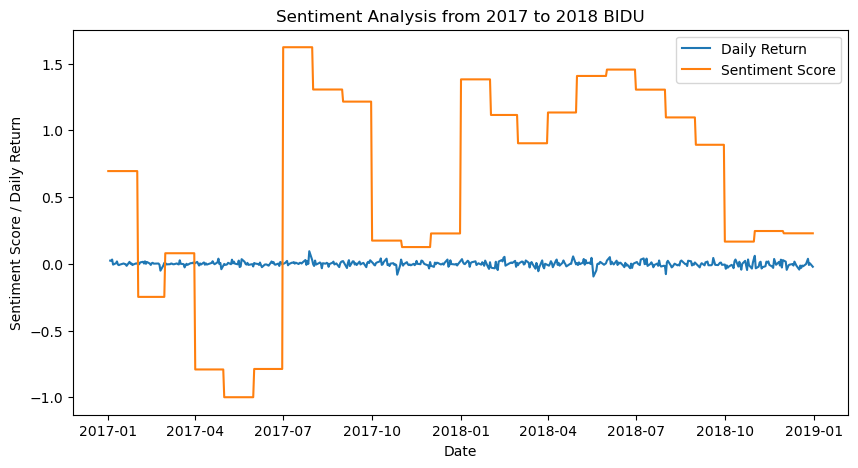

In [68]:
# plot sentiment distribution for each company
for company in selected_companies:
    temp = df_stock[df_stock['Company'] == company]
    start_date = '2017-01-01'
    end_date = '2018-12-31'
    stock = temp[(temp['Date'] >= start_date) & (temp['Date'] <= end_date)]
    stock = stock.rename(columns={"monthly_daily_return_median": "daily_return"})
    temp = df_sentiment[df_sentiment['Company'] == company]
    sentiment = temp[(temp['Date'] >= start_date) & (temp['Date'] <= end_date)]
    plt.figure(figsize=(10, 5))
    # sns.lineplot(data=df_sentiment[df_sentiment['Company'] == company], x='Date', y='sentiment')
    sns.lineplot(data=stock, x='Date', y='daily_return', label='Daily Return')
    sns.lineplot(data=sentiment, x='Date', y='sentiment', label='Sentiment Score')
    plt.title(f'Sentiment Analysis from 2017 to 2018 {company}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score / Daily Return')
    plt.legend()
    plt.show()


Model and Dataset Class

In [87]:
# dataset class
class StockPriceDataset(Dataset):
    def __init__(self, data, window_size, output_dim):
        self.window_size = window_size
        self.data = data
        self.output_dim = output_dim
        self.normalize()
        self.sequenced_data = self.sequence_data()

    def normalize(self):
        
        # normalize data
        self.data["daily_return"] = (self.data["daily_return"] - self.data["daily_return"].min()) / (self.data["daily_return"].max() - self.data["daily_return"].min() + 1e-8)
        self.data["sentiment"] = (self.data["sentiment"] - self.data["sentiment"].min()) / (self.data["sentiment"].max() - self.data["sentiment"].min() + 1e-8)
        self.data["sentiment_company"] = (self.data["sentiment_company"] - self.data["sentiment_company"].min()) / (self.data["sentiment_company"].max() - self.data["sentiment_company"].min() + 1e-8)
        self.data["sentiment_industry"] = (self.data["sentiment_industry"] - self.data["sentiment_industry"].min()) / (self.data["sentiment_industry"].max() - self.data["sentiment_industry"].min() + 1e-8)

    # create sequences by seperating each month data into seperate sequence
    def sequence_data(self):
        data = self.data
        list_of_df = []
        temp = data.copy()
        temp = temp.reset_index()
        temp["Date"] = pd.to_datetime(temp["Date"])
        all_available_dates = temp["Date"].unique()
    
        for i in range(len(all_available_dates)):
            date = all_available_dates[i]
            temp_df = data[data.index == date]
            list_of_df.append(temp_df)
        return list_of_df
        

    def __len__(self):
        return len(self.sequenced_data) - self.window_size - self.output_dim + 1

    def __getitem__(self, idx):
        if self.window_size == 1:
            sequences = self.sequenced_data[idx]
            data = sequences
        else:
            sequences = self.sequenced_data[idx: idx + self.window_size]
            data = pd.concat(sequences, axis=0)
            # data = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq.values).float() for seq in sequences], batch_first=True)
        x = data.iloc[:, :].values
        # x = data
        if self.window_size == 1:
            sequences_output = self.sequenced_data[idx: idx + self.output_dim]
            data_output = sequences_output[0]
        else:
            sequences_output = self.sequenced_data[idx : idx + self.window_size + self.output_dim]
            data_output = pd.concat(sequences_output, axis=0)
        y = data_output.iloc[-self.output_dim:, -1:].values
        return torch.tensor(x).float().to(device), torch.tensor(y).float().to(device)
        # return x.to(device), torch.tensor(y).float().to(device)
    
    def return_sequences(self, idx):
        return self.sequenced_data[idx: idx+1]

In [88]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout

        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=2, kernel_size=3, stride=1)
        if num_layers == 1:
            self.lstm = nn.LSTM(2, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        else:
            self.lstm = nn.LSTM(2, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # if num_layers == 1:
        #     self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        # else:
        #     self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        # self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = x.permute(0, 2, 1)
        
        _, (hidden_n, _) = self.lstm(x)
        
        out = self.fc(hidden_n[-1, :, :])

        return out 

Create Dataset and DataLoader, Set Hyperparameters and Build Model

In [146]:
# Hyperparameters
window_size = 365  # sequence length for each input of time series data
# input_dim = df_merged.shape[1] # number of features
input_dim = 4
hidden_dim = 20 # number of hidden units
num_layers = 2 # number of LSTM layers
# output_dims = [30,90,180,360] # predict next specified days 
output_dims = [180] # predict next specified days
num_epochs = 20
batch_size = 32
learning_rate = 1e-3
dropout = 0.2
weight_decay = 1e-2
learning_rate_decay = 1e-1
learning_rate_step_size = 25
num_workers = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_every = 5
print("device: ", device)

device:  cuda


In [133]:
# create dataset and dataloader
output_dim = 180
# train, validation, test split
# temp = df_merged.iloc[:int(0.8*len(df_merged))]
# train = temp.iloc[:int(0.8*len(temp))]
# val = temp.iloc[int(0.8*len(temp)):]
# test = df_merged.iloc[int(0.8*len(df_merged)):]
# train = df_merged[(df_merged.index >= '2012-01-01') & (df_merged.index <= '2018-12-31')]
# val = df_merged[(df_merged.index >= '2019-01-01') & (df_merged.index <= '2021-11-30')]
# test = df_merged[(df_merged.index >= '2021-12-01') & (df_merged.index <= '2021-12-31')]
train = df_merged_company[(df_merged_company.index >= '2012-01-01') & (df_merged_company.index <= '2018-12-31')]
val = df_merged_company[(df_merged_company.index >= '2019-01-01') & (df_merged_company.index <= '2021-12-30')]
test = df_merged_company[(df_merged_company.index >= '2020-01-01') & (df_merged_company.index <= '2022-12-31')]

# create dataset
train = StockPriceDataset(train, window_size, output_dim)
val = StockPriceDataset(val, window_size, output_dim)
test = StockPriceDataset(test, window_size, output_dim)

# create dataloader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [134]:
for item in test_loader:
    print(item[0].shape)
    print(item[1].shape)
    break

torch.Size([32, 365, 4])
torch.Size([32, 180, 1])


In [ ]:
# initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_step_size, gamma=learning_rate_decay)


Train Model

In [130]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # plt.savefig("./dump/losses.png")
    # plt.close()

In [ ]:
# training loop
train_losses = []
val_losses = []
previous_val_loss = 0.0
val_loss_increase_count = 0
save_current_model = True
current_best_model = None
current_best_optimizer = None

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    num_train_batches = 0
    num_val_batches = 0

    # train model
    model.train()
    for sequence in train_loader:
        inputs, targets = sequence
        targets = targets.squeeze(-1) # remove last dimension
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_train_batches += 1
    
    # validate model
    model.eval()
    with torch.no_grad():
        for sequence in val_loader:
            inputs, targets = sequence
            targets = targets.squeeze(-1) # remove last dimension

            output = model(inputs)
            loss = criterion(output, targets)
            
            val_loss += loss.item()
            num_val_batches += 1
    
    if val_loss > previous_val_loss:
        val_loss_increase_count += 1
        print('Validation loss increased! ', val_loss_increase_count)
        if save_current_model:
            current_best_model = copy.deepcopy(model.state_dict())
            current_best_optimizer = copy.deepcopy(optimizer.state_dict())
            save_current_model = False
    else:
        val_loss_increase_count = 0
        save_current_model = True
    
    if val_loss_increase_count >= 5:
        # restore the best model
        model.load_state_dict(current_best_model)
        optimizer.load_state_dict(current_best_optimizer)
        val_loss_increase_count = 0
        # reduce learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] *= learning_rate_decay
    previous_val_loss = val_loss
    
    scheduler.step()
    train_loss /= num_train_batches
    val_loss /= num_val_batches
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))
plot_losses(train_losses, val_losses)

In [ ]:
# Save the trained model
model_name = 'lstm-'
# company_name = 'apple-'
# company_name = 'microsoft-'
# company_name = 'google-'
# company_name = 'meta-'
company_name = 'yelp-'
predoction_months = '6-'
path = model_dir + model_name + company_name + predoction_months + '.pth'
torch.save(model.state_dict(), path)


In [62]:
# save dataset in pickle file
# test_dataset_name = 'test_dataset.pkl'
test_dataset_name = 'test_dataset-'
# company_name = 'apple-'
# company_name = 'microsoft-'
# company_name = 'google-'
# company_name = 'yelp-'
company_name = 'Meta-'
predoction_months = '30-'
path = data_dir + test_dataset_name + company_name + predoction_months + '.pkl'
with open(path, 'wb') as f:
    # pickle.dump(test, f)
    pickle.dump(train, f)

Epoch: 1 	Training Loss: 0.085204 	Validation Loss: 0.165665
Epoch: 2 	Training Loss: 0.072405 	Validation Loss: 0.149126
overwrite model
Epoch: 3 	Training Loss: 0.061308 	Validation Loss: 0.133156
overwrite model
Epoch: 4 	Training Loss: 0.050390 	Validation Loss: 0.115927
overwrite model
Epoch: 5 	Training Loss: 0.038445 	Validation Loss: 0.095040
overwrite model
Epoch: 6 	Training Loss: 0.025174 	Validation Loss: 0.072007
overwrite model
Epoch: 7 	Training Loss: 0.014789 	Validation Loss: 0.057613
overwrite model
Epoch: 8 	Training Loss: 0.010081 	Validation Loss: 0.051042
overwrite model
Epoch: 9 	Training Loss: 0.007917 	Validation Loss: 0.047164
overwrite model
Epoch: 10 	Training Loss: 0.006631 	Validation Loss: 0.044542
overwrite model
Epoch: 11 	Training Loss: 0.005782 	Validation Loss: 0.042689
overwrite model
Epoch: 12 	Training Loss: 0.005197 	Validation Loss: 0.041351
overwrite model
Epoch: 13 	Training Loss: 0.004783 	Validation Loss: 0.040371
overwrite model
Epoch: 14 	

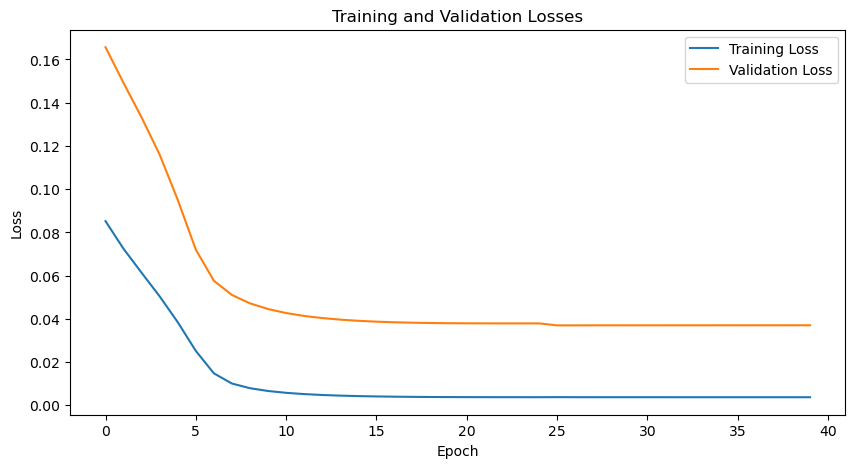

In [136]:
# train model using list of companies

error_list = []
error_list_test_data = []
for index, company in enumerate(selected_companies):
    df_merged_company = df_merged_list[index]

    for output_dim in output_dims:

        try:
            # create dataset and dataloader =================================================

            # train, validation, test split
            train = df_merged_company[(df_merged_company.index >= '2012-01-01') & (df_merged_company.index <= '2018-12-31')]
            val = df_merged_company[(df_merged_company.index >= '2019-01-01') & (df_merged_company.index <= '2021-12-31')]
            test = df_merged_company[(df_merged_company.index >= '2020-01-01') & (df_merged_company.index <= '2022-12-31')]

            # create dataset
            train = StockPriceDataset(train, window_size, output_dim)
            val = StockPriceDataset(val, window_size, output_dim)
            test = StockPriceDataset(test, window_size, output_dim)

            # create dataloader
            train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=num_workers)
            val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
            test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

            # check if test_loader works
            try:
                for item in test_loader:
                    pass
            except:
                print('test_loader does not work! ', {company})
                error_list_test_data.append(company)


            # suppress SettingWithCopyWarning
            pd.options.mode.chained_assignment = None

            # initialize model, loss function, and optimizer =================================
            model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
            criterion = nn.HuberLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_step_size, gamma=learning_rate_decay)

            # training loop
            train_losses = []
            val_losses = []
            best_val_loss = 0.0
            val_loss_increase_count = 0
            save_current_model = True
            current_best_model = None
            current_best_optimizer = None

            for epoch in range(num_epochs):
                train_loss = 0.0
                val_loss = 0.0
                num_train_batches = 0
                num_val_batches = 0

                # train model
                model.train()
                for sequence in train_loader:
                    inputs, targets = sequence
                    targets = targets.squeeze(-1) # remove last dimension
                    optimizer.zero_grad()
                    output = model(inputs)
                    loss = criterion(output, targets)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    num_train_batches += 1
                
                # validate model
                model.eval()
                with torch.no_grad():
                    for sequence in val_loader:
                        inputs, targets = sequence
                        targets = targets.squeeze(-1) # remove last dimension

                        output = model(inputs)
                        loss = criterion(output, targets)
                        
                        val_loss += loss.item()
                        num_val_batches += 1
                
                scheduler.step()
                train_loss /= num_train_batches
                val_loss /= num_val_batches
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))

                if best_val_loss == 0.0:
                    best_val_loss = val_loss

                # save the best model
                if val_loss < best_val_loss:
                    print("overwrite model")
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), f"model/lstm-{company}-{output_dim}-.pth")
                torch.save(model.state_dict(), f"model/lstm-{company}-{output_dim}-.pth")
            plot_losses(train_losses, val_losses)

            # save dataset in pickle file
            test_dataset_name = 'test_dataset-'
            company_name = company + '-' 
            predoction_days = output_dim.__str__() + '-'
            path = data_dir + test_dataset_name + company_name + predoction_days + '.pkl'
            with open(path, 'wb') as f:
                pickle.dump(test, f)
        except:
            print("error", {company})
            error_list.append(company)
    